In [1]:
!pip install keras pandas matplotlib torch opencv-python seaborn ultralytics scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [2]:
# -------------------- Imports --------------------

import os
import csv
import keras
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
import torch
import cv2
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [31]:
# -------------------- Config --------------------

DATASET_ROOT_DIR = "../dataset/leaf-dataset"
YOLO_MATCHED_DS_DIR = f'{DATASET_ROOT_DIR}/yolo_matched'
DATA_YAML_NAME = "data.yaml"
YOLO_RUNS_DIR = '../yolo-runs/yolo11n-leaf-detector'

TRAIN_SPLIT_RATIO = 0.8
VALIDATION_SPLIT_RATIO = 0.1
TEST_SPLIT_RATIO = 0.1

SEED = 42
BASE_MODEL = 'yolo11n.pt'
EPOCHS = 60
PATIENCE = 10
BATCH_SIZE = 8
INPUT_IMAGE_SIZE = 640

random.seed(SEED)

In [22]:
# -------------------- Helper functions --------------------

def csv_to_dataframe(csv_filepath, columns_name):
    df = pd.read_csv(csv_filepath, names=columns_name, header=0)
    return df


def calc_percentage(df_total, df_part, file_id_column):
    part = len(df_part[file_id_column].unique())
    total = len(df_total[file_id_column].unique())
    return (part / total) * 100


def dict_to_yaml(data):
    yaml_lines = []
    for key, value in data.items():
        if key == 'format':
            if value == 'line_break':
                yaml_lines.append('')
        elif isinstance(value, list):
            yaml_lines.append(f"{key}: {value}")
        else:
            yaml_lines.append(f"{key}: {value}")
    return '\n'.join(yaml_lines)


def create_yaml_data(yaml_file_name, output_dir, data):
    yaml_content = dict_to_yaml(data)
    output_path = os.path.join(output_dir, yaml_file_name)
    os.makedirs(output_dir, exist_ok=True)
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f'YAML file created successfully in {output_path}.')


def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height


def dataframe_yolofiles(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data = {}
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = int(row['width'])
        img_height = int(row['height'])
        bbox = eval(row['bbox'])
        x, y, width, height = bbox
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
        if image_id not in data:
            data[image_id] = []
        data[image_id].append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    for image_id, bboxes in data.items():
        output_file_path = os.path.join(output_dir, os.path.splitext(image_id)[0] + ".txt")
        with open(output_file_path, 'w') as f:
            for bbox in bboxes:
                f.write(bbox + "\n")
    print(f'Total text files created in: {output_dir}')


def move_images_to_directory(df, root_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    unique_image_ids = df['image_id'].unique()
    for image_id in unique_image_ids:
        source_path = os.path.join(root_dir, image_id)
        target_path = os.path.join(target_dir, image_id)
        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f"Warning: Image {image_id} not found on path {source_path}")
    print(f'Total images moved to: {target_dir}')


def leaf_detect(img_path, model):
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    return detect_img


def plot_images_with_detections(images_dir, labels_dir, num_images=16, grid_size=(4, 4), figsize=(16, 16)):
    image_files = os.listdir(images_dir)
    image_files.sort()
    images_forshow = image_files[:num_images]
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, image_file in enumerate(images_forshow):
        row = i // grid_size[1]
        col = i % grid_size[1]
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (250, 221, 47), 3)
        axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
    plt.show()


def show_csv_results(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0, 0])
    sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0, 1])
    sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1, 0])
    sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1, 1])
    sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2, 0])
    sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2, 1])
    sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3, 0])
    sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3, 1])
    sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4, 0])
    sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4, 1])
    axs[0, 0].set(title='Train Box Loss')
    axs[0, 1].set(title='Train Class Loss')
    axs[1, 0].set(title='Train DFL Loss')
    axs[1, 1].set(title='Metrics Precision (B)')
    axs[2, 0].set(title='Metrics Recall (B)')
    axs[2, 1].set(title='Metrics mAP50 (B)')
    axs[3, 0].set(title='Metrics mAP50-95 (B)')
    axs[3, 1].set(title='Validation Box Loss')
    axs[4, 0].set(title='Validation Class Loss')
    axs[4, 1].set(title='Validation DFL Loss')
    plt.suptitle('Training Metrics and Loss', fontsize=24)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout()
    plt.show()


def show_directory_images(directory, num_images, rows=3, columns=3):
    archivos_imagen = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(archivos_imagen))):
        img_path = os.path.join(directory, archivos_imagen[i])
        img = cv2.imread(img_path)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(img)
        ax.axis('off')
    for j in range(num_images, rows * columns):
        ax = fig.add_subplot(rows, columns, j + 1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def show_metrics(metrics):
    ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])
    ax.set_title('YOLO Evaluation Metrics')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center',
                    va='bottom')
    plt.show()


def show_detections(images_dir, num_images=16, rows=4, columns=4):
    image_files = os.listdir(images_dir)
    selected_images = random.sample(image_files, num_images)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 15))
    for i, img_file in enumerate(selected_images):
        row_idx = i // columns
        col_idx = i % columns
        img_path = os.path.join(images_dir, img_file)
        detect_img = leaf_detect(img_path, model)
        axes[row_idx, col_idx].imshow(detect_img)
        axes[row_idx, col_idx].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


def show_image(img_path):
    img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [23]:
# -------------------- Split dataset --------------------

columns_name = ['image_id', 'width', 'height', 'bbox']
csv_filepath = f'{DATASET_ROOT_DIR}/train.csv'

annotations = csv_to_dataframe(csv_filepath, columns_name)
df = pd.DataFrame(annotations)

unique_filenames = df['image_id'].unique()
train_filenames, val_test_filenames = train_test_split(unique_filenames, train_size=TRAIN_SPLIT_RATIO,
                                                       random_state=SEED)
train_df = df[df['image_id'].isin(train_filenames)]

temp_ratio = TEST_SPLIT_RATIO / (VALIDATION_SPLIT_RATIO + TEST_SPLIT_RATIO)
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=temp_ratio, random_state=SEED)
val_df = df[df['image_id'].isin(val_filenames)]
test_df = df[df['image_id'].isin(test_filenames)]

In [24]:
# -------------------- Evaluate Datasets --------------------

train_percentage = calc_percentage(df, train_df, 'image_id')
print(f'Elements in train_df({train_percentage}%):', len(train_df['image_id'].unique()))

val_percentage = calc_percentage(df, val_df, 'image_id')
print(f'Elements in val_df({val_percentage}%):', len(val_df['image_id'].unique()))

test_percentage = calc_percentage(df, test_df, 'image_id')
print(f'Elements in test_df({test_percentage}%):', len(test_df['image_id'].unique()))

Elements in train_df(80.0%): 904
Elements in val_df(10.0%): 113
Elements in test_df(10.0%): 113


In [25]:
# -------------------- Create YAML data file for YOLO --------------------

yaml_data = {
    'train': os.path.abspath(f'{YOLO_MATCHED_DS_DIR}/train/images'),
    'val': os.path.abspath(f'{YOLO_MATCHED_DS_DIR}/valid/images'),
    'test': os.path.abspath(f'{YOLO_MATCHED_DS_DIR}/test/images'),
    'format': 'line_break',
    'nc': 1,
    'names': ['leaf']
}

create_yaml_data(DATA_YAML_NAME, YOLO_MATCHED_DS_DIR, yaml_data)

YAML file created successfully in /content/dataset/leaf_dataset/yolo_matched/data.yaml.


In [26]:
# -------------------- Move images into intended folders --------------------

all_images_path = f'{DATASET_ROOT_DIR}/train/'

# Data for train
train_labels = f'{YOLO_MATCHED_DS_DIR}/train/labels'
train_images = f'{YOLO_MATCHED_DS_DIR}/train/images'
move_images_to_directory(train_df, all_images_path, train_images)
dataframe_yolofiles(train_df, train_labels)

# Data for validation
valid_labels = f'{YOLO_MATCHED_DS_DIR}/valid/labels'
valid_images = f'{YOLO_MATCHED_DS_DIR}/valid/images'
move_images_to_directory(val_df, all_images_path, valid_images)
dataframe_yolofiles(val_df, valid_labels)

# Data for test
test_labels = f'{YOLO_MATCHED_DS_DIR}/test/labels'
test_images = f'{YOLO_MATCHED_DS_DIR}/test/images'
move_images_to_directory(test_df, all_images_path, test_images)
dataframe_yolofiles(test_df, test_labels)

Total images moved to: /content/dataset/leaf_dataset/yolo_matched/train/images
Total text files created in: /content/dataset/leaf_dataset/yolo_matched/train/labels
Total images moved to: /content/dataset/leaf_dataset/yolo_matched/valid/images
Total text files created in: /content/dataset/leaf_dataset/yolo_matched/valid/labels
Total images moved to: /content/dataset/leaf_dataset/yolo_matched/test/images
Total text files created in: /content/dataset/leaf_dataset/yolo_matched/test/labels


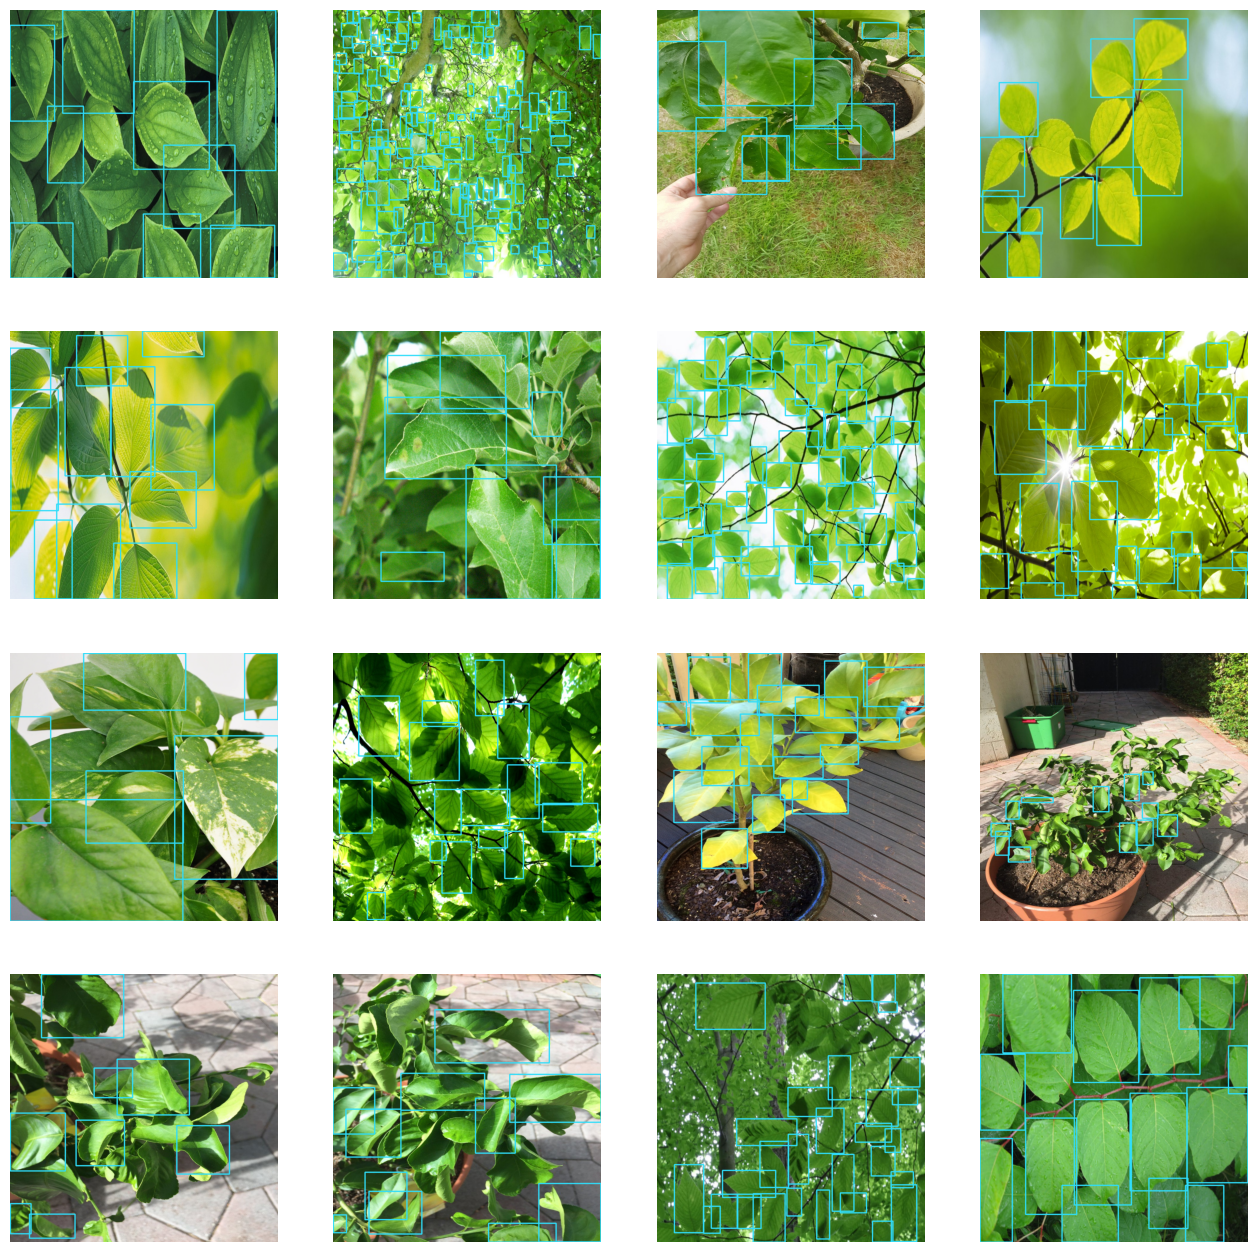

In [27]:
# -------------------- Plot train dataset --------------------

plot_images_with_detections(train_images, train_labels)

In [28]:
# -------------------- Select base YOLO model --------------------

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = YOLO(BASE_MODEL)

print(f"Using device: {device}")

Using device: cuda


In [32]:
# -------------------- Train model --------------------

model.train(data = f'{YOLO_MATCHED_DS_DIR}/{DATA_YAML_NAME}',
            epochs = EPOCHS,
            imgsz = INPUT_IMAGE_SIZE,
            seed = SEED,
            batch = BATCH_SIZE,
            device = device,
            patience = PATIENCE,
            project = YOLO_RUNS_DIR,
            workers = 4)

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/leaf_dataset/yolo_matched/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, p

train: Scanning /content/dataset/leaf_dataset/yolo_matched/train/labels.cache... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 324.8±165.9 MB/s, size: 28.1 KB)


val: Scanning /content/dataset/leaf_dataset/yolo_matched/valid/labels.cache... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      5.88G      1.374      1.508      1.521         58        640: 100%|██████████| 113/113 [00:22<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


                   all        113        532        0.6      0.531      0.545       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      5.88G      1.394      1.498      1.519         45        640: 100%|██████████| 113/113 [00:21<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        113        532       0.55      0.477      0.482      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      5.88G       1.39      1.486      1.528         49        640: 100%|██████████| 113/113 [00:20<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        113        532      0.465      0.532      0.454      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      5.88G      1.415      1.529      1.557         51        640: 100%|██████████| 113/113 [00:21<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


                   all        113        532      0.562      0.523      0.507      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      5.88G       1.39      1.481       1.55         93        640: 100%|██████████| 113/113 [00:21<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        113        532      0.552      0.492      0.512      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      5.88G      1.419      1.469      1.558         87        640: 100%|██████████| 113/113 [00:20<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        113        532      0.557      0.519      0.493      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      5.88G      1.398      1.476       1.54         61        640: 100%|██████████| 113/113 [00:20<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]

                   all        113        532      0.565      0.534      0.524      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      5.88G      1.399      1.453      1.535         42        640: 100%|██████████| 113/113 [00:21<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]

                   all        113        532      0.587      0.517      0.555      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      5.88G       1.37      1.422       1.52         53        640: 100%|██████████| 113/113 [00:21<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        113        532      0.522      0.568      0.539      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      5.88G      1.371      1.405      1.518         61        640: 100%|██████████| 113/113 [00:22<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]

                   all        113        532      0.621      0.485      0.549      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      5.88G      1.337      1.361      1.484         68        640: 100%|██████████| 113/113 [00:20<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        113        532      0.529      0.579      0.565      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      5.88G      1.333      1.361      1.495         49        640: 100%|██████████| 113/113 [00:22<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        113        532      0.577      0.575      0.573      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      5.88G      1.344      1.347      1.483         43        640: 100%|██████████| 113/113 [00:21<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]


                   all        113        532      0.567      0.541       0.53      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      5.88G      1.321      1.342      1.479         76        640: 100%|██████████| 113/113 [00:21<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


                   all        113        532      0.604       0.53      0.564      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      5.88G      1.316       1.33       1.48         31        640: 100%|██████████| 113/113 [00:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

                   all        113        532      0.571      0.577      0.578      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      5.88G      1.296      1.313      1.466         48        640: 100%|██████████| 113/113 [00:20<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        113        532      0.538      0.503      0.491      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      5.88G      1.305      1.302      1.475         57        640: 100%|██████████| 113/113 [00:21<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        113        532      0.622      0.549      0.606      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      5.88G      1.324      1.303      1.477         85        640: 100%|██████████| 113/113 [00:21<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        113        532      0.637      0.575      0.595      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      5.88G      1.276       1.27      1.448         38        640: 100%|██████████| 113/113 [00:20<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

                   all        113        532      0.577      0.523      0.558      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      5.88G      1.275      1.249      1.456         41        640: 100%|██████████| 113/113 [00:19<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]

                   all        113        532      0.625      0.523      0.565      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      5.88G      1.264      1.217      1.441         38        640: 100%|██████████| 113/113 [00:21<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]


                   all        113        532      0.564      0.547      0.547       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      5.88G      1.289      1.237      1.447         43        640: 100%|██████████| 113/113 [00:22<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        113        532      0.589      0.608      0.601      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      5.88G      1.269      1.215      1.434         47        640: 100%|██████████| 113/113 [00:20<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

                   all        113        532      0.575      0.575      0.568      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      5.88G      1.245      1.192      1.424         39        640: 100%|██████████| 113/113 [00:19<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]

                   all        113        532      0.599      0.587      0.623      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      5.88G      1.239      1.195      1.416        128        640: 100%|██████████| 113/113 [00:20<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


                   all        113        532      0.562      0.611      0.573      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      5.88G       1.23      1.225      1.423         80        640: 100%|██████████| 113/113 [00:21<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]

                   all        113        532      0.557      0.619      0.615      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      5.88G       1.22      1.175      1.402         37        640: 100%|██████████| 113/113 [00:19<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        113        532      0.611      0.551      0.613       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      5.88G      1.193      1.139      1.383         56        640: 100%|██████████| 113/113 [00:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]

                   all        113        532      0.648      0.554       0.63      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      5.88G      1.199      1.125      1.379         76        640: 100%|██████████| 113/113 [00:21<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

                   all        113        532      0.544      0.602      0.591      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      5.88G      1.208      1.132      1.391         83        640: 100%|██████████| 113/113 [00:20<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

                   all        113        532      0.556       0.62      0.599      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      5.88G      1.211      1.128      1.388         46        640: 100%|██████████| 113/113 [00:19<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.13it/s]

                   all        113        532      0.629      0.564      0.621      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      5.88G      1.196      1.111      1.391         53        640: 100%|██████████| 113/113 [00:22<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]

                   all        113        532      0.622      0.618       0.63      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      5.88G      1.204      1.107      1.391        115        640: 100%|██████████| 113/113 [00:20<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]


                   all        113        532      0.642      0.547      0.609      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      5.88G      1.206      1.136      1.395         87        640: 100%|██████████| 113/113 [00:20<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


                   all        113        532      0.616      0.625      0.635      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      5.88G      1.155      1.055      1.359         83        640: 100%|██████████| 113/113 [00:19<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        113        532      0.619      0.626      0.659      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      5.88G      1.158      1.056       1.36        116        640: 100%|██████████| 113/113 [00:20<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        113        532       0.62      0.656      0.657      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      5.88G      1.185      1.083      1.361         45        640: 100%|██████████| 113/113 [00:21<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


                   all        113        532      0.583      0.669      0.652      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      5.88G      1.162      1.074      1.358         87        640: 100%|██████████| 113/113 [00:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]

                   all        113        532      0.582      0.662      0.653       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      5.88G      1.153      1.053      1.356        121        640: 100%|██████████| 113/113 [00:20<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]

                   all        113        532      0.614      0.624      0.654      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      5.88G       1.15      1.045      1.347         53        640: 100%|██████████| 113/113 [00:21<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        113        532      0.656        0.6      0.662      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      5.88G      1.128      1.027      1.342         85        640: 100%|██████████| 113/113 [00:21<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


                   all        113        532      0.589      0.652      0.642      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      5.88G      1.154      1.032      1.352         31        640: 100%|██████████| 113/113 [00:20<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all        113        532      0.615      0.658      0.672      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      5.88G      1.151      1.051      1.339         46        640: 100%|██████████| 113/113 [00:21<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]

                   all        113        532      0.589      0.624      0.638      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      5.88G      1.121      1.012      1.334         68        640: 100%|██████████| 113/113 [00:21<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        113        532      0.564      0.702       0.66      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      5.88G      1.117      1.017      1.331        162        640: 100%|██████████| 113/113 [00:21<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.39it/s]

                   all        113        532      0.582      0.664      0.655      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      5.88G      1.118      1.031      1.332         64        640: 100%|██████████| 113/113 [00:20<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        113        532      0.654      0.588      0.658      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      5.88G      1.116     0.9871       1.33         43        640: 100%|██████████| 113/113 [00:20<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        113        532      0.599      0.641      0.665       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      5.88G      1.094     0.9747      1.312         81        640: 100%|██████████| 113/113 [00:21<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]

                   all        113        532      0.592      0.675      0.662      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      5.88G      1.112     0.9804      1.317         46        640: 100%|██████████| 113/113 [00:19<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]

                   all        113        532      0.629      0.639      0.665      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      5.88G      1.097     0.9678      1.316         66        640: 100%|██████████| 113/113 [00:19<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

                   all        113        532      0.633      0.619      0.656      0.448


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      5.88G      1.053      0.932      1.298         26        640: 100%|██████████| 113/113 [00:21<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

                   all        113        532      0.618      0.657      0.653      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      5.88G      1.007     0.8673      1.272         29        640: 100%|██████████| 113/113 [00:20<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

                   all        113        532      0.629       0.63      0.662      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      5.88G      1.023     0.8555       1.28         30        640: 100%|██████████| 113/113 [00:20<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.64it/s]

                   all        113        532        0.6      0.684      0.673      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      5.88G      1.007     0.8389      1.267        146        640: 100%|██████████| 113/113 [00:19<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        113        532      0.602      0.658      0.663      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      5.88G      1.003     0.8452      1.274         24        640: 100%|██████████| 113/113 [00:20<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        113        532      0.653      0.628      0.675      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      5.88G     0.9997     0.8313      1.262         15        640: 100%|██████████| 113/113 [00:19<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]

                   all        113        532      0.636       0.62       0.67      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      5.88G     0.9855     0.8231      1.244         21        640: 100%|██████████| 113/113 [00:19<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]

                   all        113        532      0.621      0.635      0.669      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      5.88G     0.9956     0.8157      1.266         20        640: 100%|██████████| 113/113 [00:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]

                   all        113        532      0.612      0.652      0.674      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      5.88G     0.9819     0.8133       1.25         62        640: 100%|██████████| 113/113 [00:19<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]

                   all        113        532      0.647      0.624       0.67      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      5.88G     0.9671     0.8022      1.233         21        640: 100%|██████████| 113/113 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

                   all        113        532      0.622      0.644      0.671      0.456



60 epochs completed in 0.373 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


                   all        113        532      0.614      0.652      0.674      0.459
Speed: 0.5ms preprocess, 5.8ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe94a2ef090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

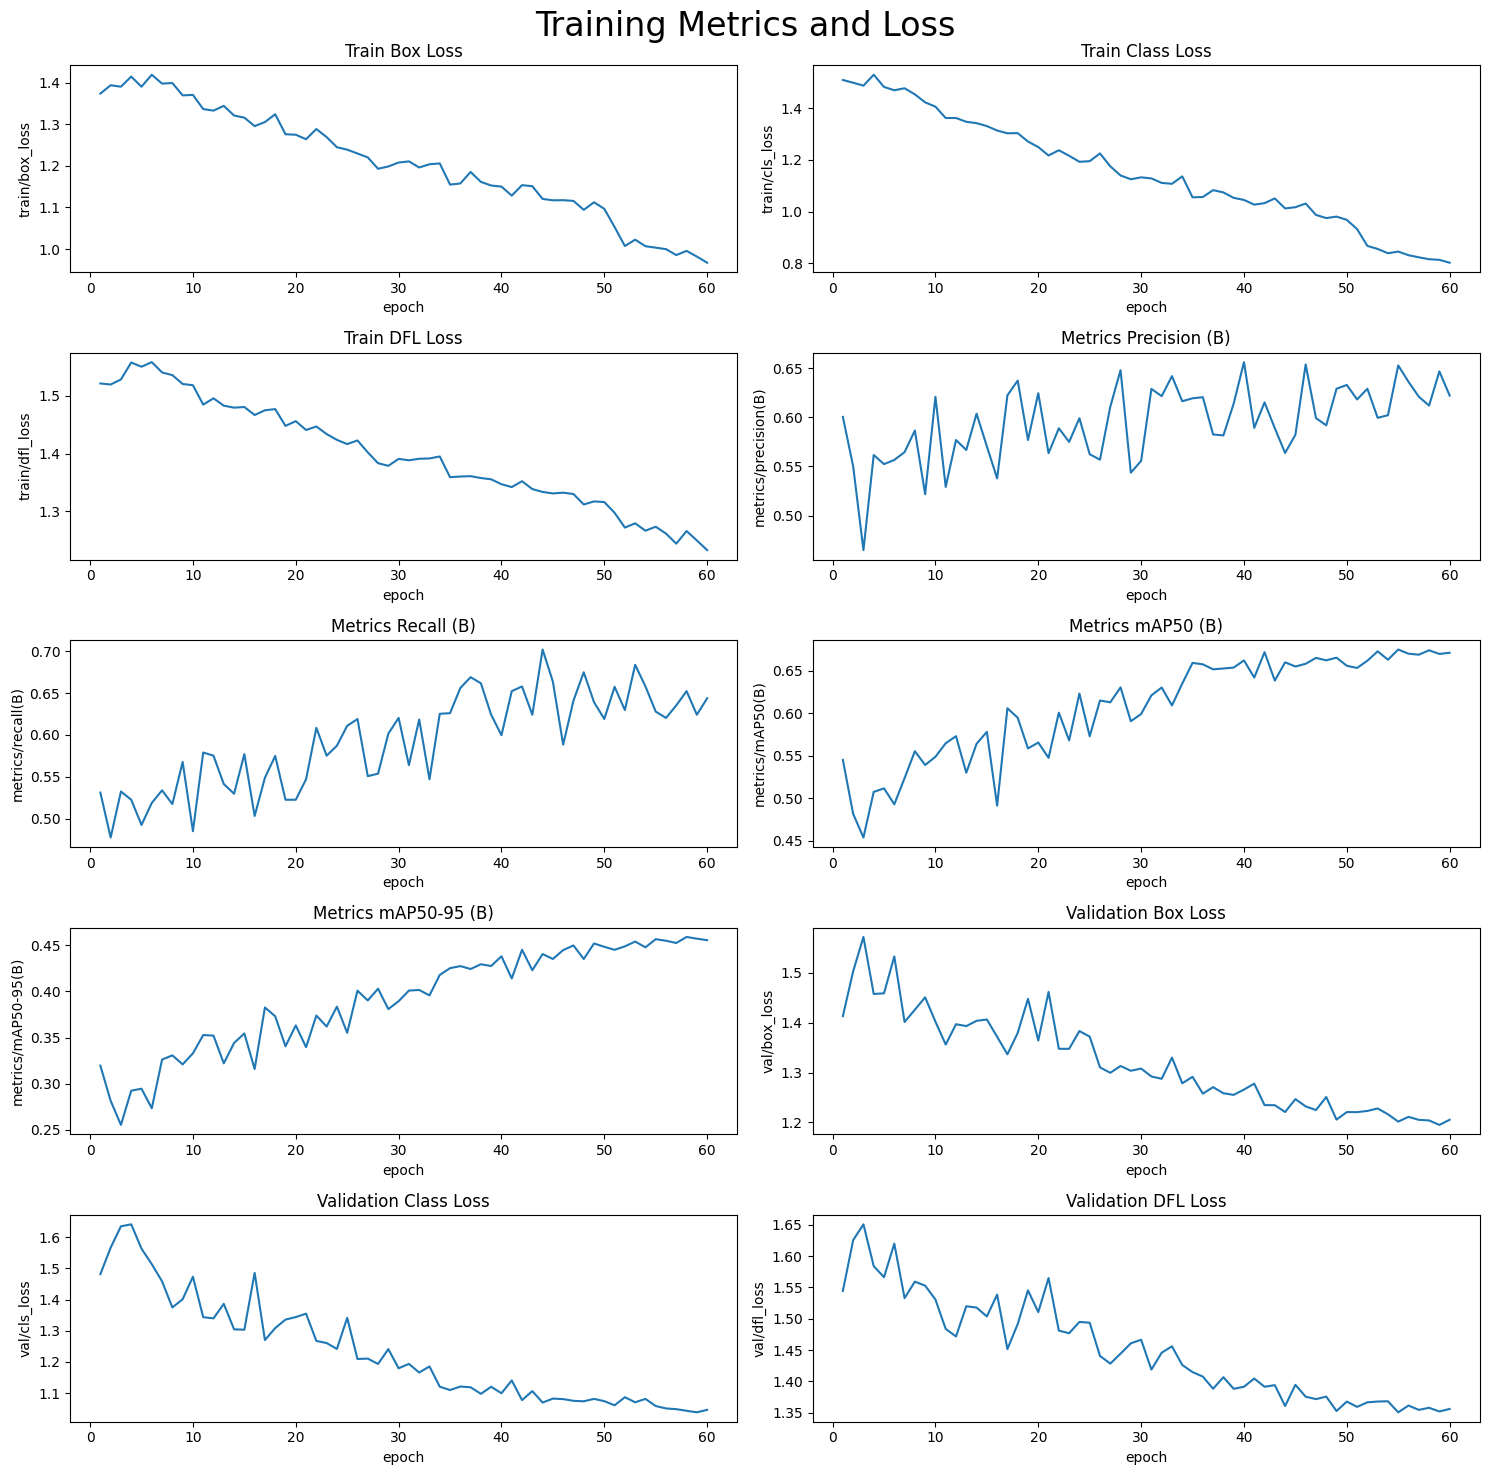

In [39]:
# -------------------- Plot metrics --------------------

show_csv_results(f'{YOLO_RUNS_DIR}/detect/train/results.csv')

In [40]:
# -------------------- Evaluate on test dataset --------------------

model = YOLO(f'{YOLO_RUNS_DIR}/detect/train/weights/best.pt')

metrics = model.val(conf=0.25, split='test')

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1365.0±798.7 MB/s, size: 164.1 KB)


val: Scanning /content/dataset/leaf_dataset/yolo_matched/test/labels.cache... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


                   all        113        626      0.676      0.692      0.717        0.5
Speed: 5.6ms preprocess, 8.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/val3


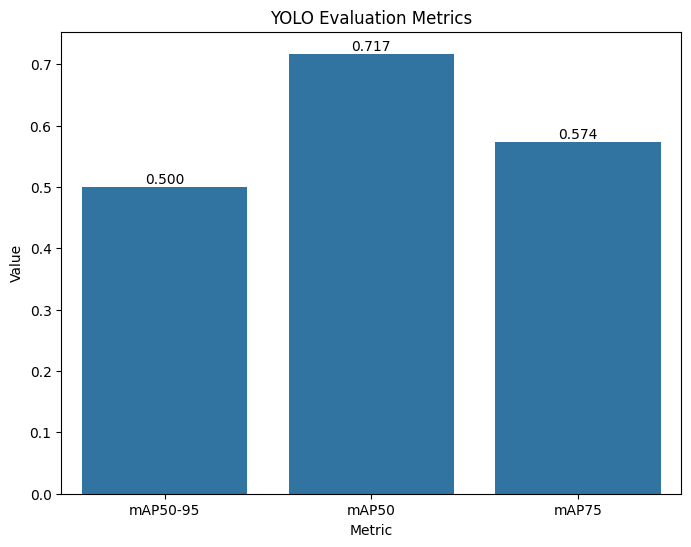

In [41]:
# -------------------- Show evaluation metrics --------------------

show_metrics(metrics)

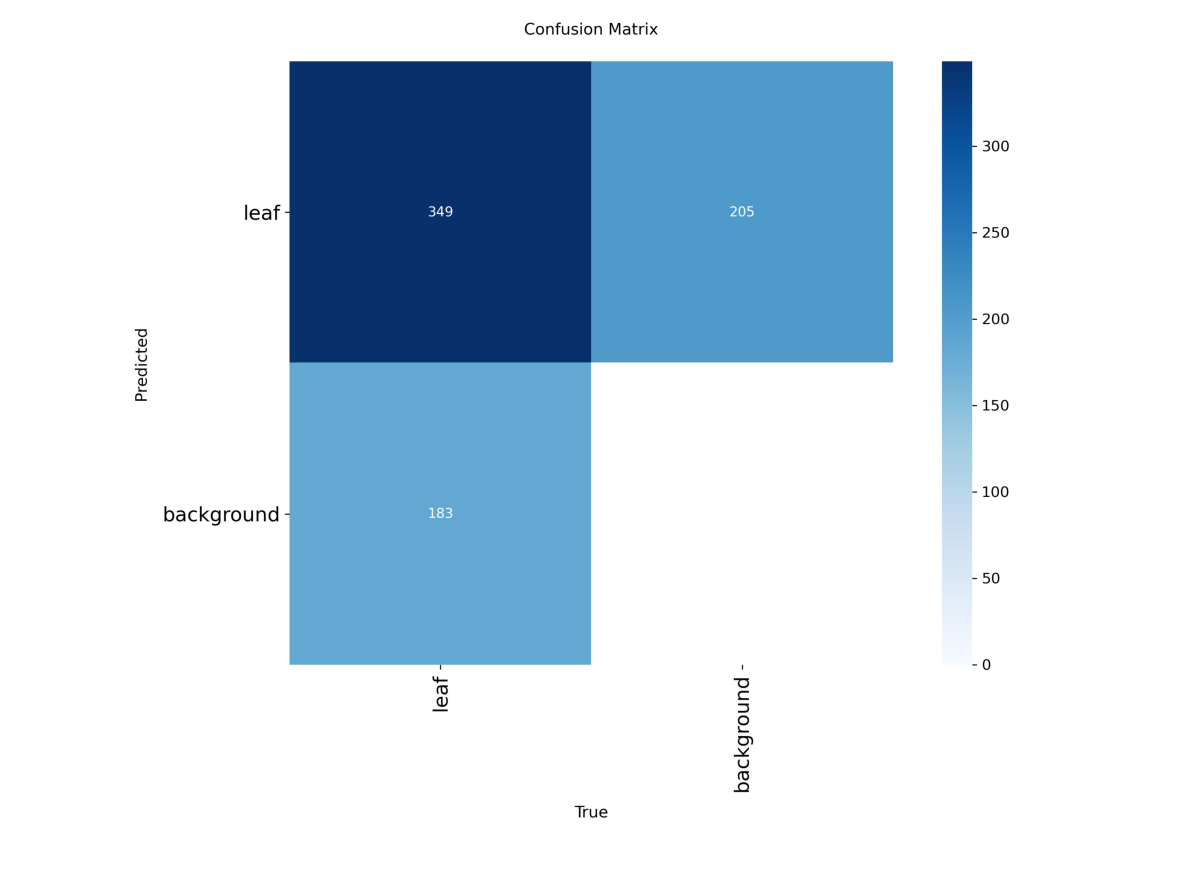

In [42]:
# -------------------- Confusion matrix --------------------

matrix_path = f'{YOLO_RUNS_DIR}/detect/train/confusion_matrix.png'
show_image(matrix_path)


0: 640x640 20 leafs, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.6ms
Speed: 3.9ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 le

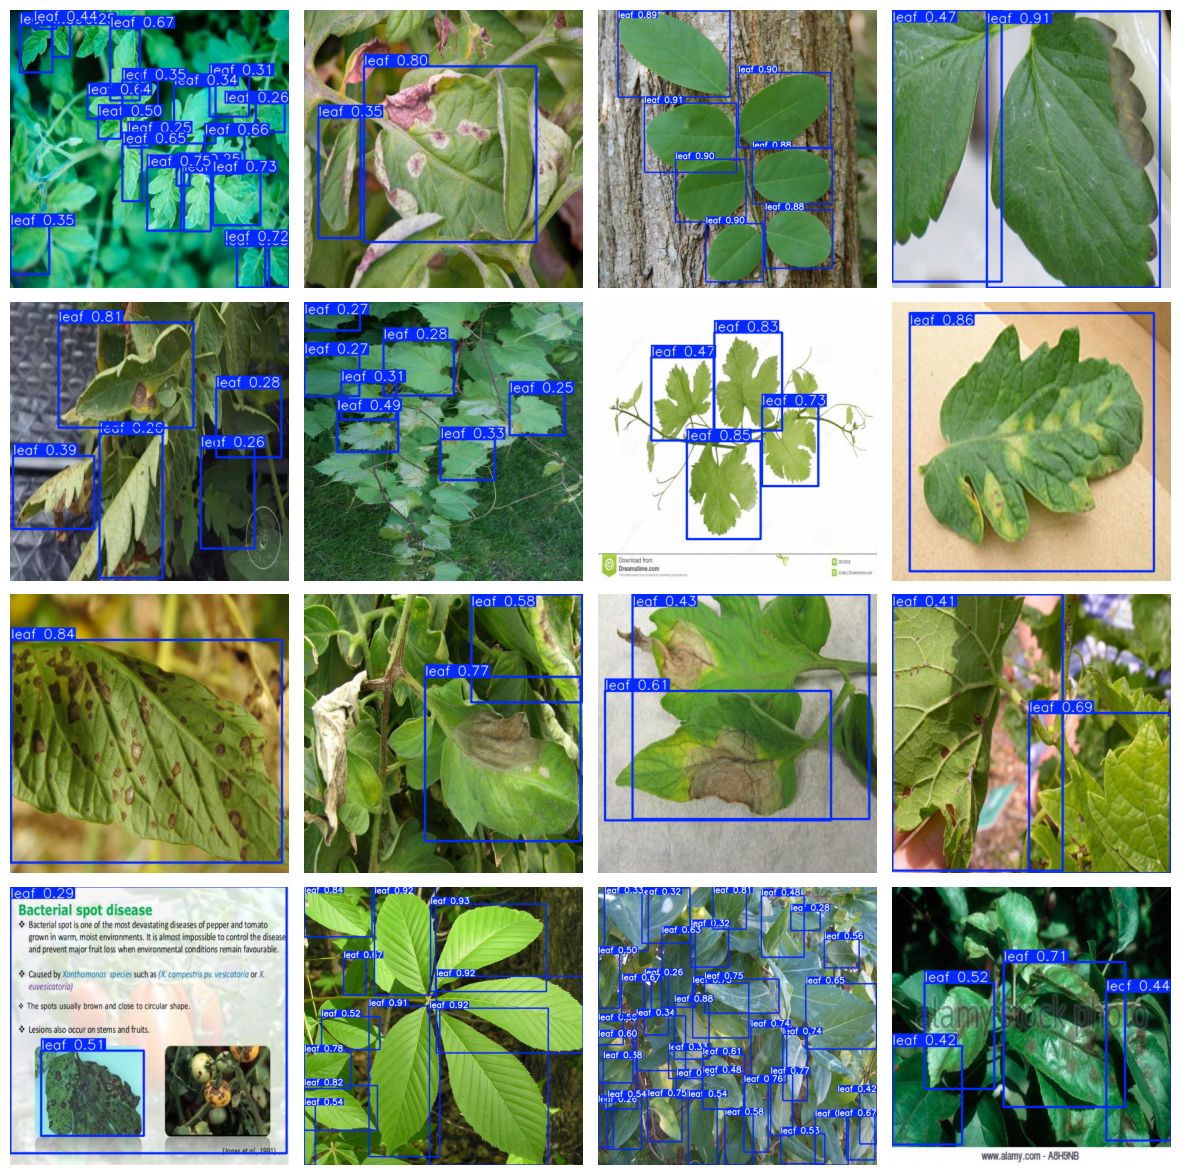

In [43]:
# -------------------- Show test detections --------------------

show_detections(test_images, num_images=16, rows=4, columns=4)